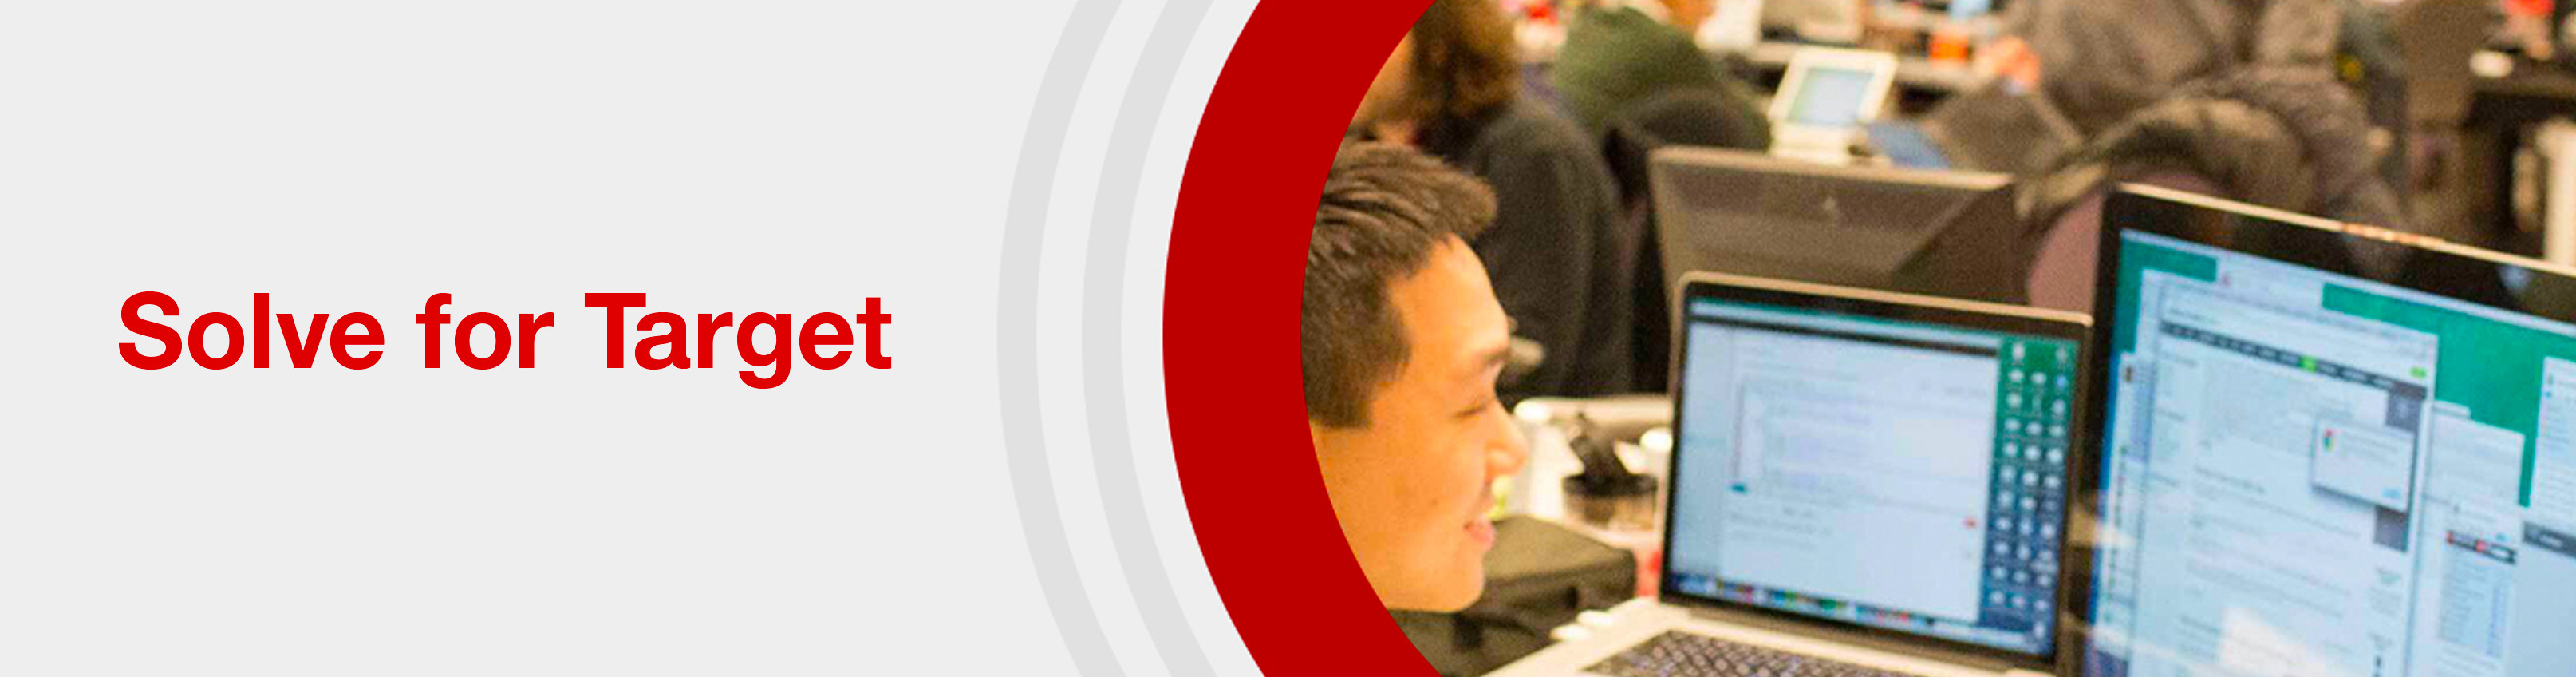


# Product Recommendations System
# Context:

Product reviews play a significant role for retailers, especially in digital channels. In the absence of a physical way to experience products, shoppers turn to feedback from other shoppers to gain insights. For retailers, understanding guest sentiment by analyzing product reviews improves how we curate products and recommendations, thereby enhancing the overall guest experience and deepening guest engagement. 

# The Challenge: 

Use the existing public guest reviews provided in the attachment to identify the underlying sentiment (positive/negative feedback) of every review. 

# Preferred tech stack

Machine Learning, please use any model that will provide good accuracy
Python

# Outcomes: 

* Create a report that identifies the bestselling products per category (UI below is only a representation)
* Derive a system to analyze the least selling products to help inform actions based on unfavorable reviews
* Solve for the problem and host it on your GitHub page. Once done, share your GitHub link with us by emailing ryse.tii@target.com

Name: Mahesh Chandra Duddu

PhNo: 9440642368, 6303817220

Email: duddumaheshchandra@gmail.com

Thanks **Target** for this wonderful opportunity.

**My way of Solving**: 

* Using reviews,rating features as independent feature, doRecommend as dependent feature, we try to estimate the probability for each reviews being positve sentiment.

* Use the model developed above to predict the probability for each title of the review being positive sentiment.

* By now, we have obtained the score for reviews, title text features. Based on this reviews, title, rating and doRecommend features we need to find out the best and least selling products.

* For this we derive a metric to obtain the score for each product based on reviews, title, rating and doRecommend features. Based on this score each product can be ranked and later decide on the best and least selling recommended products.

* Metric to evaluate score for product = doRecommend + Rating + reviews_probability + title_probability.

* Final outcome would be best and least selling product along with its rating, best/worst review along with title. This helps in improving the product or know about the product more on why its selling is best/worse.

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk

#import stopwords and text processing libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

# import sentiment intensity analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

#import machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.preprocessing import LabelEncoder, StandardScaler
import sklearn.metrics as metrics
from sklearn.compose import ColumnTransformer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Loading Dataset**

In [132]:
data = pd.read_excel('/content/data.xlsx')

In [133]:
data

,product,source,categories,date,didPurchase,doRecommend,rating,reviews,title
0,electronics brand product name Tablet A 10.1 T...,Target,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",2021-01-13T00:00:00.000Z,NaN,1.0,5.0,This product so far has not disappointed. My c...,brand name
1,electronics brand product name Tablet A 10.1 T...,Target,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",2021-01-13T00:00:00.000Z,NaN,1.0,5.0,great for beginner or experienced person. Boug...,very fast
2,electronics brand product name Tablet A 10.1 T...,Target,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",2021-01-13T00:00:00.000Z,NaN,1.0,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.
3,electronics brand product name Tablet A 10.1 T...,Target,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",2021-01-13T00:00:00.000Z,NaN,1.0,4.0,I've had my XYZ brand HD 8 two weeks now and I...,Good!!!
4,electronics brand product name Tablet A 10.1 T...,Target,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",2021-01-12T00:00:00.000Z,NaN,1.0,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids
...,...,...,...,...,...,...,...,...,...
34655,NaN,Target,"Computers/Tablets & Networking,Tablet & eBook ...",2012-09-18T00:00:00Z,NaN,NaN,3.0,This is not appreciably faster than any other ...,Not appreciably faster than any other 1.8A cha...
34656,NaN,Target,"Computers/Tablets & Networking,Tablet & eBook ...",2012-11-21T00:00:00Z,NaN,NaN,1.0,Target should include this charger with the br...,Should be included
34657,NaN,Target,"Computers/Tablets & Networking,Tablet & eBook ...",2012-10-19T00:00:00Z,NaN,NaN,1.0,Love my brand name XYZ brand but I am really d...,Disappointing Charger
34658,NaN,Target,"Computers/Tablets & Networking,Tablet & eBook ...",2012-10-31T00:00:00Z,NaN,NaN,1.0,I was surprised to find it did not come with a...,Not worth the money


# Basic Exploratory Data Analysis(EDA)

**Shape of dataset**

In [134]:
data.shape

(34660, 9)

**Summary of data**

In [135]:
data.describe(include = 'all')

,product,source,categories,date,didPurchase,doRecommend,rating,reviews,title
count,27900,34660,34660,34621,1.0,34066.000000,34627.000000,34658,34655
unique,60,6,44,1078,NaN,NaN,NaN,34658,19687
top,"XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...",Target,"XYZ brand Tablets,Tablets,Computers & Tablets,...",2021-01-16T00:00:00.000Z,NaN,NaN,NaN,This product so far has not disappointed. My c...,Great product
freq,10966,28701,10966,710,NaN,NaN,NaN,1,645
mean,NaN,NaN,NaN,NaN,1.0,0.959373,4.584573,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,0.197427,0.735653,NaN,NaN
min,NaN,NaN,NaN,NaN,1.0,0.000000,1.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,1.0,1.000000,4.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,1.0,1.000000,5.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,1.0,1.000000,5.000000,NaN,NaN


**Type of data present in datset**

In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   product      27900 non-null  object 
 1   source       34660 non-null  object 
 2   categories   34660 non-null  object 
 3   date         34621 non-null  object 
 4   didPurchase  1 non-null      float64
 5   doRecommend  34066 non-null  float64
 6   rating       34627 non-null  float64
 7   reviews      34658 non-null  object 
 8   title        34655 non-null  object 
dtypes: float64(3), object(6)
memory usage: 2.4+ MB


**Null Values**

In [137]:
data.isnull().sum()*100/len(data)

product        19.503751
source          0.000000
categories      0.000000
date            0.112522
didPurchase    99.997115
doRecommend     1.713791
rating          0.095211
reviews         0.005770
title           0.014426
dtype: float64

*didPurchase feature can be removed as 99% of values are null, and date feature can also be removed*



**Duplicates**

In [138]:
data.duplicated().sum()

0

**Unique Values**

In [139]:
data.nunique()

product           60
source             6
categories        44
date            1078
didPurchase        1
doRecommend        2
rating             5
reviews        34658
title          19687
dtype: int64

**Value Counts**

In [140]:
cols = data.columns.to_list()
for i in cols:
  print("**************************")
  print(data[i].value_counts())

**************************
XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta                                                                                                                                                        10966
retail brand brand name Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,,,                                                                                                                 3176
electronics brand product name Tablet A 10.1 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta                                                                                                                  2814
retail brand XYZ brand Tv,,,_x000D_\nretail brand XYZ brand Tv,,,                                                                                                                                                                   2526
electonics brand Home_x000D_\nelectonics 

In [141]:
# Removing date and didPurchase feature
data.drop(['didPurchase', 'date'], axis = 1, inplace = True)

In [142]:
impure_data = data.copy()

In [143]:
#Lets also remove rows where there are null values
data.dropna(axis = 0, how = 'any', inplace = True)

In [144]:
data.reset_index(drop = True, inplace = True)

In [145]:
#lets see the cleaned data shape
data.shape

(27406, 7)

In [146]:
#lets see number of null values
data.isnull().sum()

product        0
source         0
categories     0
doRecommend    0
rating         0
reviews        0
title          0
dtype: int64


Guest 

# Text preprocessing
Making some functions that we will need ahead for Preprocessing text data.

Lowercase - It is necessary to convert the text to lower case as it is case sensitive.

remove punctuations - The punctuations present in the text do not add value to the data. The punctuation, when attached to any word, will create a problem in differentiating with other words. so we have to get rid of them.

remove stopwords - Stopwords include: I, he, she, and, but, was were, being, have, etc, which do not add meaning to the data. So these words must be removed which helps to reduce the features from our data. These are removed after tokenizing the text.

stemming - A technique that takes the word to its root form. It just removes suffixes from the words. The stemmed word might not be part of the dictionary, i.e it will not necessarily give meaning.

lemmatizing - Takes the word to its root form called Lemma. It helps to bring words to their dictionary form. It is applied to nouns by default. It is more accurate as it uses more informed analysis to create groups of words with similar meanings based on the context, so it is complex and takes more time. This is used where we need to retain the contextual information.

In [147]:
# create a function for preprocessing 
def preprocessing_text(text):
  #convert all to lowercase
    text = text.lower()
  #remove puntuations
    text = text.translate(text.maketrans('', '', string.punctuation))
  #remove stopword
    stop_word = set(stopwords.words('english'))
    text_tokens = word_tokenize(text)
    filtered_words = [word for word in text_tokens if word not in stop_word]
  #stemming
    ps = PorterStemmer()
    Stemmed_words = [ps.stem(w) for w in filtered_words] 

  #lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos = 'a') for w in Stemmed_words]
    return " ".join(lemma_words)

In [148]:
data['doRecommend'].value_counts()

1.0    26256
0.0     1150
Name: doRecommend, dtype: int64

There is huge Class Imbalance!

In [149]:
data['reviews_cleaned'] = data['reviews'].astype(str).apply(preprocessing_text)
data['title_cleaned'] = data['title'].astype(str).apply(preprocessing_text)

# Predicting probability of doRecommend features to be 1 using reviews and rating feature 

Based on the assumption, Guest only recommends a product only if the guest posts positive review on a product machine learning model is built.

Using TF-IDF technique for converting text features to numerical(unigrams, bigrams, trigrams)

In [150]:
# Split data into X, y
X_review = data.loc[:,['reviews_cleaned','rating']]
y_review = data.loc[:,['doRecommend']]

X_title = data.loc[:, ['title_cleaned', 'rating']]
y_title = data.loc[:, ['doRecommend']]

In [151]:
# TF-IDF Vectorizer with maximum features limited to 100 with unigram,bigram and trigrams as features.
tfidf = TfidfVectorizer(max_features=100, ngram_range=(1,3))
t = tfidf.fit_transform(X_review['reviews_cleaned'])
df = pd.DataFrame(t.toarray(), index = range(0,X_review.shape[0]), columns = tfidf.get_feature_names_out())

X_review = pd.concat([X_review, df], axis = 1)
X_review.drop(['reviews_cleaned'], axis = 1, inplace = True)

t = tfidf.transform(X_title['title_cleaned'])
df = pd.DataFrame(t.toarray(), index = range(0,X_title.shape[0]), columns = tfidf.get_feature_names_out())

X_title = pd.concat([X_title, df], axis = 1)
X_title.drop(['title_cleaned'], axis = 1, inplace = True)
X_review.reset_index(drop = True, inplace = True)
X_title.reset_index(drop = True, inplace = True)

In [152]:
X_review

,rating,abl,alexa,also,app,ask,batteri,best,book,bought,...,want,watch,well,work,work great,would,xyz,xyz brand,year,year old
0,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.514420,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,4.0,0.198317,0.000000,0.000000,0.294397,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.197401,0.168258,0.0,0.0,0.0,0.320101,0.321619,0.0,0.0
4,5.0,0.000000,0.000000,0.243839,0.000000,0.000000,0.0,0.239830,0.0,0.360045,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27401,5.0,0.156390,0.274153,0.000000,0.000000,0.000000,0.0,0.273442,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
27402,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.298681,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
27403,4.0,0.000000,0.235839,0.000000,0.000000,0.273098,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
27404,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [153]:
y_review

,doRecommend
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
27401,1.0
27402,1.0
27403,1.0
27404,0.0


['rating',
 'abl',
 'alexa',
 'also',
 'app',
 'ask',
 'batteri',
 'best',
 'book',
 'bought',
 'brand',
 'brand name',
 'brand name xyz',
 'buy',
 'cant',
 'christma',
 'control',
 'could',
 'daughter',
 'day',
 'devic',
 'dont',
 'download',
 'easi',
 'easi use',
 'echo',
 'enjoy',
 'even',
 'everyth',
 'featur',
 'first',
 'fun',
 'game',
 'get',
 'gift',
 'go',
 'good',
 'got',
 'great',
 'great tablet',
 'happi',
 'home',
 'im',
 'ipad',
 'kid',
 'learn',
 'life',
 'light',
 'like',
 'littl',
 'long',
 'look',
 'lot',
 'love',
 'make',
 'mani',
 'movi',
 'much',
 'music',
 'name',
 'name xyz',
 'name xyz brand',
 'need',
 'new',
 'nice',
 'old',
 'one',
 'paperwhit',
 'perfect',
 'play',
 'price',
 'product',
 'purchas',
 'qualiti',
 'read',
 'reader',
 'realli',
 'recommend',
 'screen',
 'set',
 'size',
 'small',
 'son',
 'sound',
 'still',
 'tablet',
 'take',
 'target',
 'thing',
 'time',
 'use',
 'want',
 'watch',
 'well',
 'work',
 'work great',
 'would',
 'xyz',
 'xyz brand',
 'year',
 'year old']

In [154]:
# Split the dataset into train and test
X_train_review, X_test_review, y_train_review, y_test_review = train_test_split(X_review, y_review, test_size=0.2, random_state = 42, stratify = y_review)

In [155]:
X_train_review.reset_index(drop = True, inplace = True)
y_train_review.reset_index(drop = True, inplace = True)

## Random Forest

In [156]:
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

test_fold_preds = []
review_fold_preds = []
title_fold_preds = []

i = 1
for train_index, test_index in skf.split(X_train_review, y_train_review):
  print("{} Fold of {} StratifiedKFold".format(i, skf.n_splits))
  xtr,xvl = X_train_review.loc[train_index], X_train_review.loc[test_index]
  ytr,yvl = y_train_review.loc[train_index], y_train_review.loc[test_index]

  rf_model_review = RandomForestClassifier(n_jobs = -1, random_state = 42, class_weight='balanced')
  rf_model_review.fit(xtr, ytr)

  tr_pred = rf_model_review.predict(xtr) #Training set predictions
  vl_pred = rf_model_review.predict(xvl) #Validation set predictions
  
  test_preds = rf_model_review.predict(X_test_review) #Predicting on Test set predictions
  test_prob = rf_model_review.predict_proba(X_test_review)[:,1] #Prediction probabilities of it belongs to class 1

  review_preds = rf_model_review.predict(X_review) #Predicting on whole reviews
  review_prob = rf_model_review.predict_proba(X_review)[:,1] #Prediction probabilities of it belongs to class 1

  title_preds = rf_model_review.predict(X_title) #Predicting on whole title of reviews
  title_prob = rf_model_review.predict_proba(X_title)[:,1] #Prediction probabilities of it belongs to class 1

  # print accuracy score
  print("----------------Training------------------")
  print("accuracy score: {}%".format(round(accuracy_score(ytr, tr_pred)*100,2)))

  #print confusion matrix
  print("Confusion Matrix: {}%".format(confusion_matrix(ytr, tr_pred)))

  #print classification report
  print("Classification Report: {}%".format(classification_report(ytr, tr_pred)))


  # print accuracy score
  print("----------------Validation------------------")
  print("accuracy score: {}%".format(round(accuracy_score(yvl, vl_pred)*100,2)))

  #print confusion matrix
  print("Confusion Matrix: {}%".format(confusion_matrix(yvl, vl_pred)))

  #print classification report
  print("Classification Report: {}%".format(classification_report(yvl, vl_pred)))
 
  
  # print accuracy score
  print("----------------Testing------------------")
  print("accuracy score: {}%".format(round(accuracy_score(y_test_review, test_preds)*100,2)))

  #print confusion matrix
  print("Confusion Matrix: {}%".format(confusion_matrix(y_test_review, test_preds)))
  
  #print classification report
  print("Classification Report: {}%".format(classification_report(y_test_review, test_preds)))


  # print accuracy score
  print("----------------Review Predictions------------------")
  print("accuracy score: {}%".format(round(accuracy_score(y_review, review_preds)*100,2)))

  #print confusion matrix
  print("Confusion Matrix: {}%".format(confusion_matrix(y_review, review_preds)))
  
  #print classification report
  print("Classification Report: {}%".format(classification_report(y_review, review_preds)))

  # print accuracy score
  print("----------------Title Predictions------------------")
  print("accuracy score: {}%".format(round(accuracy_score(y_title, title_preds)*100,2)))

  #print confusion matrix
  print("Confusion Matrix: {}%".format(confusion_matrix(y_title, title_preds)))
  
  #print classification report
  print("Classification Report: {}%".format(classification_report(y_title, review_preds)))

  test_fold_preds.append(test_preds)
  review_fold_preds.append(review_prob)
  title_fold_preds.append(title_prob)
  i+=1

1 Fold of 10 StratifiedKFold


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


----------------Training------------------
accuracy score: 99.9%
Confusion Matrix: [[  827     1]
 [   19 18884]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       828
         1.0       1.00      1.00      1.00     18903

    accuracy                           1.00     19731
   macro avg       0.99      1.00      0.99     19731
weighted avg       1.00      1.00      1.00     19731
%
----------------Validation------------------
accuracy score: 97.22%
Confusion Matrix: [[  45   47]
 [  14 2087]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.76      0.49      0.60        92
         1.0       0.98      0.99      0.99      2101

    accuracy                           0.97      2193
   macro avg       0.87      0.74      0.79      2193
weighted avg       0.97      0.97      0.97      2193
%
----------------Testing------------------
accuracy score: 97.5%
Confu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


----------------Training------------------
accuracy score: 99.87%
Confusion Matrix: [[  827     1]
 [   24 18879]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       828
         1.0       1.00      1.00      1.00     18903

    accuracy                           1.00     19731
   macro avg       0.99      1.00      0.99     19731
weighted avg       1.00      1.00      1.00     19731
%
----------------Validation------------------
accuracy score: 97.4%
Confusion Matrix: [[  48   44]
 [  13 2088]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.79      0.52      0.63        92
         1.0       0.98      0.99      0.99      2101

    accuracy                           0.97      2193
   macro avg       0.88      0.76      0.81      2193
weighted avg       0.97      0.97      0.97      2193
%
----------------Testing------------------
accuracy score: 97.52%
Conf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


----------------Training------------------
accuracy score: 99.87%
Confusion Matrix: [[  827     1]
 [   24 18879]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       828
         1.0       1.00      1.00      1.00     18903

    accuracy                           1.00     19731
   macro avg       0.99      1.00      0.99     19731
weighted avg       1.00      1.00      1.00     19731
%
----------------Validation------------------
accuracy score: 97.63%
Confusion Matrix: [[  59   33]
 [  19 2082]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.76      0.64      0.69        92
         1.0       0.98      0.99      0.99      2101

    accuracy                           0.98      2193
   macro avg       0.87      0.82      0.84      2193
weighted avg       0.97      0.98      0.98      2193
%
----------------Testing------------------
accuracy score: 97.56%
Con

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


----------------Training------------------
accuracy score: 99.87%
Confusion Matrix: [[  827     1]
 [   25 18878]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       828
         1.0       1.00      1.00      1.00     18903

    accuracy                           1.00     19731
   macro avg       0.99      1.00      0.99     19731
weighted avg       1.00      1.00      1.00     19731
%
----------------Validation------------------
accuracy score: 97.08%
Confusion Matrix: [[  54   38]
 [  26 2075]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.68      0.59      0.63        92
         1.0       0.98      0.99      0.98      2101

    accuracy                           0.97      2193
   macro avg       0.83      0.79      0.81      2193
weighted avg       0.97      0.97      0.97      2193
%
----------------Testing------------------
accuracy score: 97.34%
Con

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


----------------Training------------------
accuracy score: 99.88%
Confusion Matrix: [[  827     1]
 [   23 18881]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       828
         1.0       1.00      1.00      1.00     18904

    accuracy                           1.00     19732
   macro avg       0.99      1.00      0.99     19732
weighted avg       1.00      1.00      1.00     19732
%
----------------Validation------------------
accuracy score: 97.17%
Confusion Matrix: [[  50   42]
 [  20 2080]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.71      0.54      0.62        92
         1.0       0.98      0.99      0.99      2100

    accuracy                           0.97      2192
   macro avg       0.85      0.77      0.80      2192
weighted avg       0.97      0.97      0.97      2192
%
----------------Testing------------------
accuracy score: 97.45%
Con

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


----------------Training------------------
accuracy score: 99.9%
Confusion Matrix: [[  828     0]
 [   20 18884]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       828
         1.0       1.00      1.00      1.00     18904

    accuracy                           1.00     19732
   macro avg       0.99      1.00      0.99     19732
weighted avg       1.00      1.00      1.00     19732
%
----------------Validation------------------
accuracy score: 97.26%
Confusion Matrix: [[  56   36]
 [  24 2076]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.70      0.61      0.65        92
         1.0       0.98      0.99      0.99      2100

    accuracy                           0.97      2192
   macro avg       0.84      0.80      0.82      2192
weighted avg       0.97      0.97      0.97      2192
%
----------------Testing------------------
accuracy score: 97.41%
Conf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


----------------Training------------------
accuracy score: 99.89%
Confusion Matrix: [[  826     2]
 [   19 18885]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       828
         1.0       1.00      1.00      1.00     18904

    accuracy                           1.00     19732
   macro avg       0.99      1.00      0.99     19732
weighted avg       1.00      1.00      1.00     19732
%
----------------Validation------------------
accuracy score: 97.35%
Confusion Matrix: [[  49   43]
 [  15 2085]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.77      0.53      0.63        92
         1.0       0.98      0.99      0.99      2100

    accuracy                           0.97      2192
   macro avg       0.87      0.76      0.81      2192
weighted avg       0.97      0.97      0.97      2192
%
----------------Testing------------------
accuracy score: 97.54%
Con

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


----------------Training------------------
accuracy score: 99.89%
Confusion Matrix: [[  827     1]
 [   20 18884]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       828
         1.0       1.00      1.00      1.00     18904

    accuracy                           1.00     19732
   macro avg       0.99      1.00      0.99     19732
weighted avg       1.00      1.00      1.00     19732
%
----------------Validation------------------
accuracy score: 97.67%
Confusion Matrix: [[  53   39]
 [  12 2088]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.82      0.58      0.68        92
         1.0       0.98      0.99      0.99      2100

    accuracy                           0.98      2192
   macro avg       0.90      0.79      0.83      2192
weighted avg       0.97      0.98      0.97      2192
%
----------------Testing------------------
accuracy score: 97.32%
Con

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


----------------Training------------------
accuracy score: 99.89%
Confusion Matrix: [[  826     2]
 [   20 18884]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       828
         1.0       1.00      1.00      1.00     18904

    accuracy                           1.00     19732
   macro avg       0.99      1.00      0.99     19732
weighted avg       1.00      1.00      1.00     19732
%
----------------Validation------------------
accuracy score: 97.86%
Confusion Matrix: [[  59   33]
 [  14 2086]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.81      0.64      0.72        92
         1.0       0.98      0.99      0.99      2100

    accuracy                           0.98      2192
   macro avg       0.90      0.82      0.85      2192
weighted avg       0.98      0.98      0.98      2192
%
----------------Testing------------------
accuracy score: 97.45%
Con

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


----------------Training------------------
accuracy score: 99.91%
Confusion Matrix: [[  827     1]
 [   17 18887]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       828
         1.0       1.00      1.00      1.00     18904

    accuracy                           1.00     19732
   macro avg       0.99      1.00      0.99     19732
weighted avg       1.00      1.00      1.00     19732
%
----------------Validation------------------
accuracy score: 97.31%
Confusion Matrix: [[  56   36]
 [  23 2077]]%
Classification Report:               precision    recall  f1-score   support

         0.0       0.71      0.61      0.65        92
         1.0       0.98      0.99      0.99      2100

    accuracy                           0.97      2192
   macro avg       0.85      0.80      0.82      2192
weighted avg       0.97      0.97      0.97      2192
%
----------------Testing------------------
accuracy score: 97.46%
Con

In [157]:
def mode_of_preds(a):
    u, c = np.unique(a, return_counts=True)
    return u[c.argmax()]

Test Predictions value Counts

In [158]:
#Mode of predictions in all folds
final_preds = np.apply_along_axis(mode_of_preds, 0, test_fold_preds)
print(final_preds)

final_preds = pd.DataFrame(np.array(final_preds))

print("Actual")
print(y_test_review.value_counts())

print("Predicted")
print(final_preds.value_counts())

[1. 1. 1. ... 1. 1. 1.]
Actual
doRecommend
1.0            5252
0.0             230
dtype: int64
Predicted
1.0    5298
0.0     184
dtype: int64


Review predictions value counts by taking mean of all predictions in folds

In [159]:
#Mean of probs in all folds
final_review_prob = np.mean(review_fold_preds, axis = 0)
data['review_prob'] = final_review_prob
final_review_class = (final_review_prob>=0.5).astype('int')

In [160]:
final_review_df = pd.DataFrame(final_review_class)
print("Actual")
print(y_review.value_counts())
print("Predicted")
final_review_df.value_counts()

Actual
doRecommend
1.0            26256
0.0             1150
dtype: int64
Predicted


1    26282
0     1124
dtype: int64

Title predictions value counts

In [161]:
#Mean of probs in all folds
final_title_prob = np.mean(title_fold_preds, axis = 0)
data['title_prob'] = final_title_prob
final_title_class = (final_title_prob>=0.5).astype('int')

In [162]:
final_title_df = pd.DataFrame(final_title_class)
print("Actual")
print(y_title.value_counts())
print("Predicted")
final_title_df.value_counts()

Actual
doRecommend
1.0            26256
0.0             1150
dtype: int64
Predicted


1    25967
0     1439
dtype: int64

# Create Score for every product, inorder to rank them later

In [165]:
data['score'] = data['doRecommend'] + data['rating'] + data['review_prob'] + data['title_prob'] 

In [232]:
data

,product,source,categories,doRecommend,rating,reviews,title,reviews_cleaned,title_cleaned,review_prob,title_prob,score
0,electronics brand product name Tablet A 10.1 T...,Target,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",1.0,5.0,This product so far has not disappointed. My c...,brand name,product far disappoint children love use like ...,brand name,0.999000,1.000000,7.999000
1,electronics brand product name Tablet A 10.1 T...,Target,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",1.0,5.0,great for beginner or experienced person. Boug...,very fast,great beginn experienc person bought gift love,fast,1.000000,1.000000,8.000000
2,electronics brand product name Tablet A 10.1 T...,Target,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",1.0,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,inexpens tablet use learn step one thrill lear...,beginn tablet 9 year old son,0.987000,1.000000,7.987000
3,electronics brand product name Tablet A 10.1 T...,Target,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",1.0,4.0,I've had my XYZ brand HD 8 two weeks now and I...,Good!!!,ive xyz brand hd 8 two week love tablet great ...,good,0.993000,1.000000,6.993000
4,electronics brand product name Tablet A 10.1 T...,Target,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",1.0,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,bought grand daughter come visit set user ente...,fantast tablet kid,0.998000,1.000000,7.998000
...,...,...,...,...,...,...,...,...,...,...,...,...
27401,New retail brand brand name XYZ brand Hd 9w Po...,Target,"Stereos,Remote Controls,Target Echo,Audio Dock...",1.0,5.0,This is my new favorite device. While not perf...,My new favorite product,new favorit devic perfect lot un useon featur ...,new favorit product,0.999000,0.999000,7.998000
27402,New retail brand brand name XYZ brand Hd 9w Po...,Target,"Stereos,Remote Controls,Target Echo,Audio Dock...",1.0,5.0,I got this to basically experiment with. Strai...,Lots of potential!!!,got basic experi straight box realli impress n...,lot potenti,0.999000,1.000000,7.999000
27403,New retail brand brand name XYZ brand Hd 9w Po...,Target,"Stereos,Remote Controls,Target Echo,Audio Dock...",1.0,4.0,Good product that does the basics. Too bad you...,Good First Generation Product,good product basic bad buy specif light contro...,good first gener product,0.990000,0.991414,6.981414
27404,New retail brand brand name XYZ brand Hd 9w Po...,Target,"Stereos,Remote Controls,Target Echo,Audio Dock...",0.0,3.0,This is great for a connected home. People who...,"Great for a ""connected home""",great connect home peopl use buy plan make eve...,great connect home,0.245096,0.553790,3.798886


In [275]:
print(data.loc[27404,['reviews']].values)

["This is great for a connected home. People who use this should buy it if they plan on making everything in their home wi-if enabled. Otherwise it's an expensive SIRI."]


In [236]:
useful_data = data[['categories', 'product', 'score']]
useful_data

,categories,product,score
0,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",electronics brand product name Tablet A 10.1 T...,7.999000
1,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",electronics brand product name Tablet A 10.1 T...,8.000000
2,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",electronics brand product name Tablet A 10.1 T...,7.987000
3,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",electronics brand product name Tablet A 10.1 T...,6.993000
4,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",electronics brand product name Tablet A 10.1 T...,7.998000
...,...,...,...
27401,"Stereos,Remote Controls,Target Echo,Audio Dock...",New retail brand brand name XYZ brand Hd 9w Po...,7.998000
27402,"Stereos,Remote Controls,Target Echo,Audio Dock...",New retail brand brand name XYZ brand Hd 9w Po...,7.999000
27403,"Stereos,Remote Controls,Target Echo,Audio Dock...",New retail brand brand name XYZ brand Hd 9w Po...,6.981414
27404,"Stereos,Remote Controls,Target Echo,Audio Dock...",New retail brand brand name XYZ brand Hd 9w Po...,3.798886


In [237]:
df = useful_data.groupby(['categories', 'product'])['score'].mean()
d = df.reset_index().sort_values(['categories','score'], ascending = False).set_index(['categories', 'product'])
d #It contains all the products ranked best to least per category

score
categories                                         product                                                     
eBook Readers,brand name E-readers,Computers & ... brand name Oasis E-reader with Leather Charging...  7.432548
brand name E-readers,Electronics Features,Compu... Brand New electronics brand IPad16gb 7 Ips Disp...  7.396398
XYZ brand Tablets,Tablets,Computers & Tablets,A... retail brand - brand name Voyage - 4GB - Wi-Fi ...  8.000000
                                                   Certified Refurbished electronics brand TV (Pre...  7.995084
                                                   XYZ brand HD 8 Tablet with Alexa, 8 HD Display,...  7.651786
...                                                                                                         ...
Computers/Tablets & Networking,Tablets & eBook ... retail brand brand name Touch Leather Case (4th...  7.984000
                                                   Brand New electronics brand IPad16gb 7 Ips Disp...  7.359378
                                                   XYZ brand Kids Edition Tablet, 7 Display, Wi-Fi...  7.245925
Computers & Tablets,Tablets,All Tablets,Compute... \nelectonics brand Home                             7.695203
Computers & Tablets,E-Readers & Accessories,eBo... Brand New electronics brand IPad16gb 7 Ips Disp...  7.847653

[72 rows x 1 columns]

In [372]:
dcp = d.copy()
dcp.reset_index(inplace = True)
dcp

,categories,product,score
0,"eBook Readers,brand name E-readers,Computers &...",brand name Oasis E-reader with Leather Chargin...,7.432548
1,"brand name E-readers,Electronics Features,Comp...",Brand New electronics brand IPad16gb 7 Ips Dis...,7.396398
2,"XYZ brand Tablets,Tablets,Computers & Tablets,...",retail brand - brand name Voyage - 4GB - Wi-Fi...,8.000000
3,"XYZ brand Tablets,Tablets,Computers & Tablets,...",Certified Refurbished electronics brand TV (Pr...,7.995084
4,"XYZ brand Tablets,Tablets,Computers & Tablets,...","XYZ brand HD 8 Tablet with Alexa, 8 HD Display...",7.651786
...,...,...,...
67,"Computers/Tablets & Networking,Tablets & eBook...",retail brand brand name Touch Leather Case (4t...,7.984000
68,"Computers/Tablets & Networking,Tablets & eBook...",Brand New electronics brand IPad16gb 7 Ips Dis...,7.359378
69,"Computers/Tablets & Networking,Tablets & eBook...","XYZ brand Kids Edition Tablet, 7 Display, Wi-F...",7.245925
70,"Computers & Tablets,Tablets,All Tablets,Comput...",\nelectonics brand Home,7.695203


In [355]:
best = d.reset_index().groupby(['categories']).nth(0) #Obtaining the best selling product per category
least = d.reset_index().groupby(['categories']).nth(-1) #Obtaining the least selling product per category

In [356]:
best

,product,score
categories,,
"Computers & Tablets,E-Readers & Accessories,eBook Readers,brand name E-readers",Brand New electronics brand IPad16gb 7 Ips Dis...,7.847653
"Computers & Tablets,Tablets,All Tablets,Computers/Tablets & Networking,Tablets & eBook Readers,XYZ brand Tablets,Frys",\nelectonics brand Home,7.695203
"Computers/Tablets & Networking,Tablets & eBook Readers,Computers & Tablets,Tablets,All Tablets",retail brand brand name Touch Leather Case (4t...,7.984000
"Electronics Features,XYZ brand Tablets,Computers & Tablets,Tablets,All Tablets,Computers/Tablets & Networking,Tablets & eBook Readers",\nelectonics brand Home,7.189600
"Electronics,Computers,Computer Accessories,Cases & Bags,XYZ brand Tablets,Electronics Features,Tablets,Computers & Tablets,Kids' Tablets,Electronics, Tech Toys, Movies, Music,iPad & Tablets,Top Rated","XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...",7.829201
"Electronics,iPad & Tablets,All Tablets,Computers & Tablets,Tablets,eBook Readers","XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...",7.490883
"Electronics,iPad & Tablets,All Tablets,Computers/Tablets & Networking,Tablets & eBook Readers,Computers & Tablets,E-Readers & Accessories,E-Readers,Used:Computers Accessories,Used:Tablets,Computers,iPads Tablets,brand name E-readers,Electronics Features",retail brand brand name XYZ brand Hd (3rd Gene...,7.999000
"Electronics,iPad & Tablets,All Tablets,XYZ brand Tablets,Tablets,Computers & Tablets",electronics brand product name Tablet A 10.1 T...,7.463557
"Stereos,Remote Controls,Target Echo,Audio Docks & Mini Speakers,Target Echo Accessories,Kitchen & Dining Features,Speaker Systems,Electronics,TVs Entertainment,Clearance,Smart Hubs & Wireless Routers,Featured Brands,Wireless Speakers,Smart Home & Connected Living,Home Security,brand name Store,Home Automation,Home, Garage & Office,Home,Voice-Enabled Smart Assistants,Virtual Assistant Speakers,Portable Audio & Headphones,Electronics Features,Target Device Accessories,iPod, Audio Player Accessories,Home & Furniture Clearance,Consumer Electronics,Smart Home,Surveillance,Home Improvement,Smart Home & Home Automation Devices,Smart Hubs,Home Safety & Security,Voice Assistants,Alarms & Sensors,Target Devices,Audio,Holiday Shop",retail brand XYZ brand 9W PowerFast Official O...,8.000000


In [357]:
best = best.reset_index()

In [358]:
least

,product,score
categories,,
"Computers & Tablets,E-Readers & Accessories,eBook Readers,brand name E-readers",Brand New electronics brand IPad16gb 7 Ips Dis...,7.847653
"Computers & Tablets,Tablets,All Tablets,Computers/Tablets & Networking,Tablets & eBook Readers,XYZ brand Tablets,Frys",\nelectonics brand Home,7.695203
"Computers/Tablets & Networking,Tablets & eBook Readers,Computers & Tablets,Tablets,All Tablets","XYZ brand Kids Edition Tablet, 7 Display, Wi-F...",7.245925
"Electronics Features,XYZ brand Tablets,Computers & Tablets,Tablets,All Tablets,Computers/Tablets & Networking,Tablets & eBook Readers",\nelectonics brand Home,7.189600
"Electronics,Computers,Computer Accessories,Cases & Bags,XYZ brand Tablets,Electronics Features,Tablets,Computers & Tablets,Kids' Tablets,Electronics, Tech Toys, Movies, Music,iPad & Tablets,Top Rated","XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...",7.829201
"Electronics,iPad & Tablets,All Tablets,Computers & Tablets,Tablets,eBook Readers","XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...",7.490883
"Electronics,iPad & Tablets,All Tablets,Computers/Tablets & Networking,Tablets & eBook Readers,Computers & Tablets,E-Readers & Accessories,E-Readers,Used:Computers Accessories,Used:Tablets,Computers,iPads Tablets,brand name E-readers,Electronics Features","XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...",7.342894
"Electronics,iPad & Tablets,All Tablets,XYZ brand Tablets,Tablets,Computers & Tablets",electronics brand product name Tablet A 10.1 T...,7.463557
"Stereos,Remote Controls,Target Echo,Audio Docks & Mini Speakers,Target Echo Accessories,Kitchen & Dining Features,Speaker Systems,Electronics,TVs Entertainment,Clearance,Smart Hubs & Wireless Routers,Featured Brands,Wireless Speakers,Smart Home & Connected Living,Home Security,brand name Store,Home Automation,Home, Garage & Office,Home,Voice-Enabled Smart Assistants,Virtual Assistant Speakers,Portable Audio & Headphones,Electronics Features,Target Device Accessories,iPod, Audio Player Accessories,Home & Furniture Clearance,Consumer Electronics,Smart Home,Surveillance,Home Improvement,Smart Home & Home Automation Devices,Smart Hubs,Home Safety & Security,Voice Assistants,Alarms & Sensors,Target Devices,Audio,Holiday Shop",New retail brand brand name XYZ brand Hd 9w Po...,6.458786


As you can see there are products which have a good score but still there in the least selling products data. Lets remove them based on score criteria.

Remove if *Score >= 5*

In [359]:
least = least.reset_index()
least_criteria_0 = least[least['score'] < 5]

In [360]:
least_criteria_0

,categories,product,score
17,"XYZ brand Tablets,Tablets,Computers & Tablets,...",retail brand - brand name Voyage - 4GB - Wi-Fi...,3.371441


Surprisingly, there is only one category and even the product is also one. So, lets deal it in this way as follows:

* Retrieve the poor review and rating for all the products present in least dataframe.

* Finally, we filter these products based on their rating criteria.

* Drop the rows(i.e products) that have rating <= 3

In [361]:
least_criteria_1 = least

In [362]:
least_criteria_1 = least_criteria_1.reset_index(drop = True)

In [368]:
def retrieve_review_rating(category, product, df, flag):
  df = df.copy()
  df = df[(df['categories'] == category)&(df['product'] == product)][['reviews', 'score', 'rating', 'doRecommend', 'review_prob', 'title_prob']]
  df = df.reset_index(drop=True).sort_values(by=['score', 'rating', 'doRecommend', 'review_prob', 'title_prob'], ascending = True).reset_index(drop = True)
  if len(df) == 0:
    return [None, None]
  elif flag == 1:
    return [df['reviews'][0], df['rating'][0]] # retrieve bad review along with poor rating
  else:
    return [df['reviews'][len(df)-1], df['rating'][len(df)-1]]# retrieve good review along with good rating


# cat = "Computers & Tablets,Tablets,All Tablets,Computers/Tablets & Networking,Tablets & eBook Readers,XYZ brand Tablets,Frys"
# prod = "\nelectonics brand Home"
# rev, rat = retrieve_review_rating(cat, prod, data, 1)
# print(rev, rat)

In [364]:
for i in range(len(least_criteria_1)):
  li = retrieve_review_rating(least_criteria_1.loc[i, 'categories'],least_criteria_1.loc[i, 'product'], data, 1)
  least_criteria_1.loc[i, 'review'], least_criteria_1.loc[i, 'rating'] = li[0],li[1]
least_criteria_1

                                              reviews     score  rating  \
0   Enjoy my summer reading and a regular tablet j...  6.673818     4.0   
1   The touch control, page change controls, are a...  6.926016     4.0   
2   This is a great reader, it feels like the best...  6.961184     4.0   
3   the back light nad easier to read in all light...  6.974592     4.0   
4   I had a hard time finding a case for it at bes...  6.985158     4.0   
5   my wife surprised me with this, and I wasn't s...  6.988392     4.0   
6   I purchase this for my wife; it work well but ...  7.000000     4.0   
7   brand name Voyage is absolutely the best! Easy...  7.927000     5.0   
8   Note, the information on the Best Buy site is ...  7.963000     5.0   
9   This is a fantastic product for reading books....  7.967000     5.0   
10  Like that I can use it in so many ways. As a c...  7.984018     5.0   
11  I had the book e reader when it first came out...  7.985000     5.0   
12  I love this e-reader.

,categories,product,score,review,rating
0,"Computers & Tablets,E-Readers & Accessories,eB...",Brand New electronics brand IPad16gb 7 Ips Dis...,7.847653,Enjoy my summer reading and a regular tablet j...,4.0
1,"Computers & Tablets,Tablets,All Tablets,Comput...",\nelectonics brand Home,7.695203,"It's was on sale on this color,put the play st...",4.0
2,"Computers/Tablets & Networking,Tablets & eBook...","XYZ brand Kids Edition Tablet, 7 Display, Wi-F...",7.245925,I I thought the buy For my child bc the kids m...,1.0
3,"Electronics Features,XYZ brand Tablets,Compute...",\nelectonics brand Home,7.189600,charging port fault appeared in tablet after 2...,1.0
4,"Electronics,Computers,Computer Accessories,Cas...","XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...",7.829201,My 3 yr old has already figured it all out. Us...,4.0
5,"Electronics,iPad & Tablets,All Tablets,Compute...","XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...",7.490883,doesnot work After three weeksI cannot open it...,3.0
6,"Electronics,iPad & Tablets,All Tablets,Compute...","XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...",7.342894,Am used to brand name XYZ brand which I love. ...,1.0
7,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",electronics brand product name Tablet A 10.1 T...,7.463557,Freeze frequently... No way to trouble shoot o...,1.0
8,"Stereos,Remote Controls,Target Echo,Audio Dock...",New retail brand brand name XYZ brand Hd 9w Po...,6.458786,This is great for a connected home. People who...,3.0
9,"Stereos,Remote Controls,retail brand Echo,Audi...","retail brand XYZ brand Tv,,,_x000D_\nretail br...",7.516157,You have to pay for every thing -any thing you...,1.0


In [365]:
# Filtering rows that have rating <= 3
final_least_selling_prods = least_criteria_1[least_criteria_1['rating'] <= 3].reset_index(drop = True)
final_least_selling_prods

,categories,product,score,review,rating
0,"Computers/Tablets & Networking,Tablets & eBook...","XYZ brand Kids Edition Tablet, 7 Display, Wi-F...",7.245925,I I thought the buy For my child bc the kids m...,1.0
1,"Electronics Features,XYZ brand Tablets,Compute...",\nelectonics brand Home,7.189600,charging port fault appeared in tablet after 2...,1.0
2,"Electronics,iPad & Tablets,All Tablets,Compute...","XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...",7.490883,doesnot work After three weeksI cannot open it...,3.0
3,"Electronics,iPad & Tablets,All Tablets,Compute...","XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...",7.342894,Am used to brand name XYZ brand which I love. ...,1.0
4,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",electronics brand product name Tablet A 10.1 T...,7.463557,Freeze frequently... No way to trouble shoot o...,1.0
5,"Stereos,Remote Controls,Target Echo,Audio Dock...",New retail brand brand name XYZ brand Hd 9w Po...,6.458786,This is great for a connected home. People who...,3.0
6,"Stereos,Remote Controls,retail brand Echo,Audi...","retail brand XYZ brand Tv,,,_x000D_\nretail br...",7.516157,You have to pay for every thing -any thing you...,1.0
7,"Tablets,XYZ brand Tablets,Computers & Tablets,...",retail brand 5W USB Official OEM Charger and P...,6.917342,Dont have option for password ask you before b...,1.0
8,"Tablets,XYZ brand Tablets,Electronics,Computer...",electronics brand product name Tablet A 10.1 T...,7.413837,I bought this because I have ebooks in college...,1.0
9,"Walmart for Business,Office Electronics,Tablet...","brand name Paperwhite E-reader - White, 6 High...",7.424877,My brand name Voyage is nearly 16 months old a...,1.0


In [369]:
for i in range(len(best)):
  li = retrieve_review_rating(best.loc[i, 'categories'],best.loc[i, 'product'], data, 0)
  best.loc[i, 'review'], best.loc[i, 'rating'] = li[0],li[1]
best

,categories,product,score,review,rating
0,"Computers & Tablets,E-Readers & Accessories,eB...",Brand New electronics brand IPad16gb 7 Ips Dis...,7.847653,Replaced original paper white with this new mo...,5.0
1,"Computers & Tablets,Tablets,All Tablets,Comput...",\nelectonics brand Home,7.695203,Great product. Highly recommended. Great value...,5.0
2,"Computers/Tablets & Networking,Tablets & eBook...",retail brand brand name Touch Leather Case (4t...,7.984000,I bought this one for a family member because ...,5.0
3,"Electronics Features,XYZ brand Tablets,Compute...",\nelectonics brand Home,7.189600,Best Black Friday deal. They were available an...,5.0
4,"Electronics,Computers,Computer Accessories,Cas...","XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...",7.829201,I love it so and so my kids.They r enjoying pl...,5.0
5,"Electronics,iPad & Tablets,All Tablets,Compute...","XYZ brand Tablet, 7 Display, Wi-Fi, 8 GB - Inc...",7.490883,You will not regret this purchase! The brand n...,5.0
6,"Electronics,iPad & Tablets,All Tablets,Compute...",retail brand brand name XYZ brand Hd (3rd Gene...,7.999000,"What is there to say, but that I love it. Func...",5.0
7,"Electronics,iPad & Tablets,All Tablets,XYZ bra...",electronics brand product name Tablet A 10.1 T...,7.463557,Several friends suggested I buy the brand name...,5.0
8,"Stereos,Remote Controls,Target Echo,Audio Dock...",retail brand XYZ brand 9W PowerFast Official O...,8.000000,It's a positive addition to the household. I e...,5.0
9,"Stereos,Remote Controls,retail brand Echo,Audi...",9W PowerFast Official OEM USB Charger and Powe...,8.000000,Alexa is the greatest product ever I use it ar...,5.0
